# How to sample from the learned distribution of solutions with the trained neural networks.



In this study, we aim to enhance the accuracy of denoising diffusion probabilistic models (DDPMs) for the task of airfoil flow field prediction by implementing various already existing conditioning mechanisms. We intend to guide the diffusion process more effectively, ensuring that the generated samples are more precise and closely aligned with CFD results.

First prepare the dataset for sampling. The class `DataFiles`  used to organize the dataset, please refer to `generate_dataset.ipynb` and `process_dataset.ipynb`

In [1]:
# run this cell to install the required packages and clone the repository if you are using colab
%pip install einops bayesian_torch
!git init
!git clone https://github.com/Slate452/Diffusion-based-Flow-Prediction.git
%cd Diffusion-based-Flow-Prediction/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.2 MB/s eta 0:00:00
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
Cloning into 'Diffusion-based-Flow-Prediction'...
remote: Enumerating objects: 522, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 522 (delta 42), reused 174 (delta 34), pack-reused 330 (from 1)
Receiving objects: 100% (522/522), 2.43 GiB | 29.20 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files

In [2]:
import zipfile
import torch
from airfoil_diffusion.airfoil_datasets import *
from airfoil_diffusion.networks import *
from airfoil_diffusion.trainer import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not os.path.exists("./datasets/1_parameter/data/"):
    files=[file for file in os.listdir("./datasets/1_parameter/") if file.endswith(".zip")]
    for file in tqdm(files):
        f=zipfile.ZipFile("./datasets/1_parameter/"+file,'r')
        for file in f.namelist():
            f.extract(file,"./datasets/1_parameter/data/")
        f.close()

df_train=FileDataFiles("./datasets/1_parameter/train_cases.txt",base_path="./datasets/1_parameter/data/")
df_test=FileDataFiles("./datasets/1_parameter/test_cases.txt",base_path="./datasets/1_parameter/data/")
df_all=DataFiles(df_train.case_list+df_test.case_list)

100%|██████████| 11/11 [00:01<00:00,  6.93it/s]


The test dataset consists of 6 simulations with raf30 airfoil. The angle of attack is 20 $\degree$ and the $Re$ ranges from $0.5 \times 10^6$ to $10.5 \times 10^6$. Let's first have a look at how the ground truth mean field and the standard deviation of these simulation cases look like:

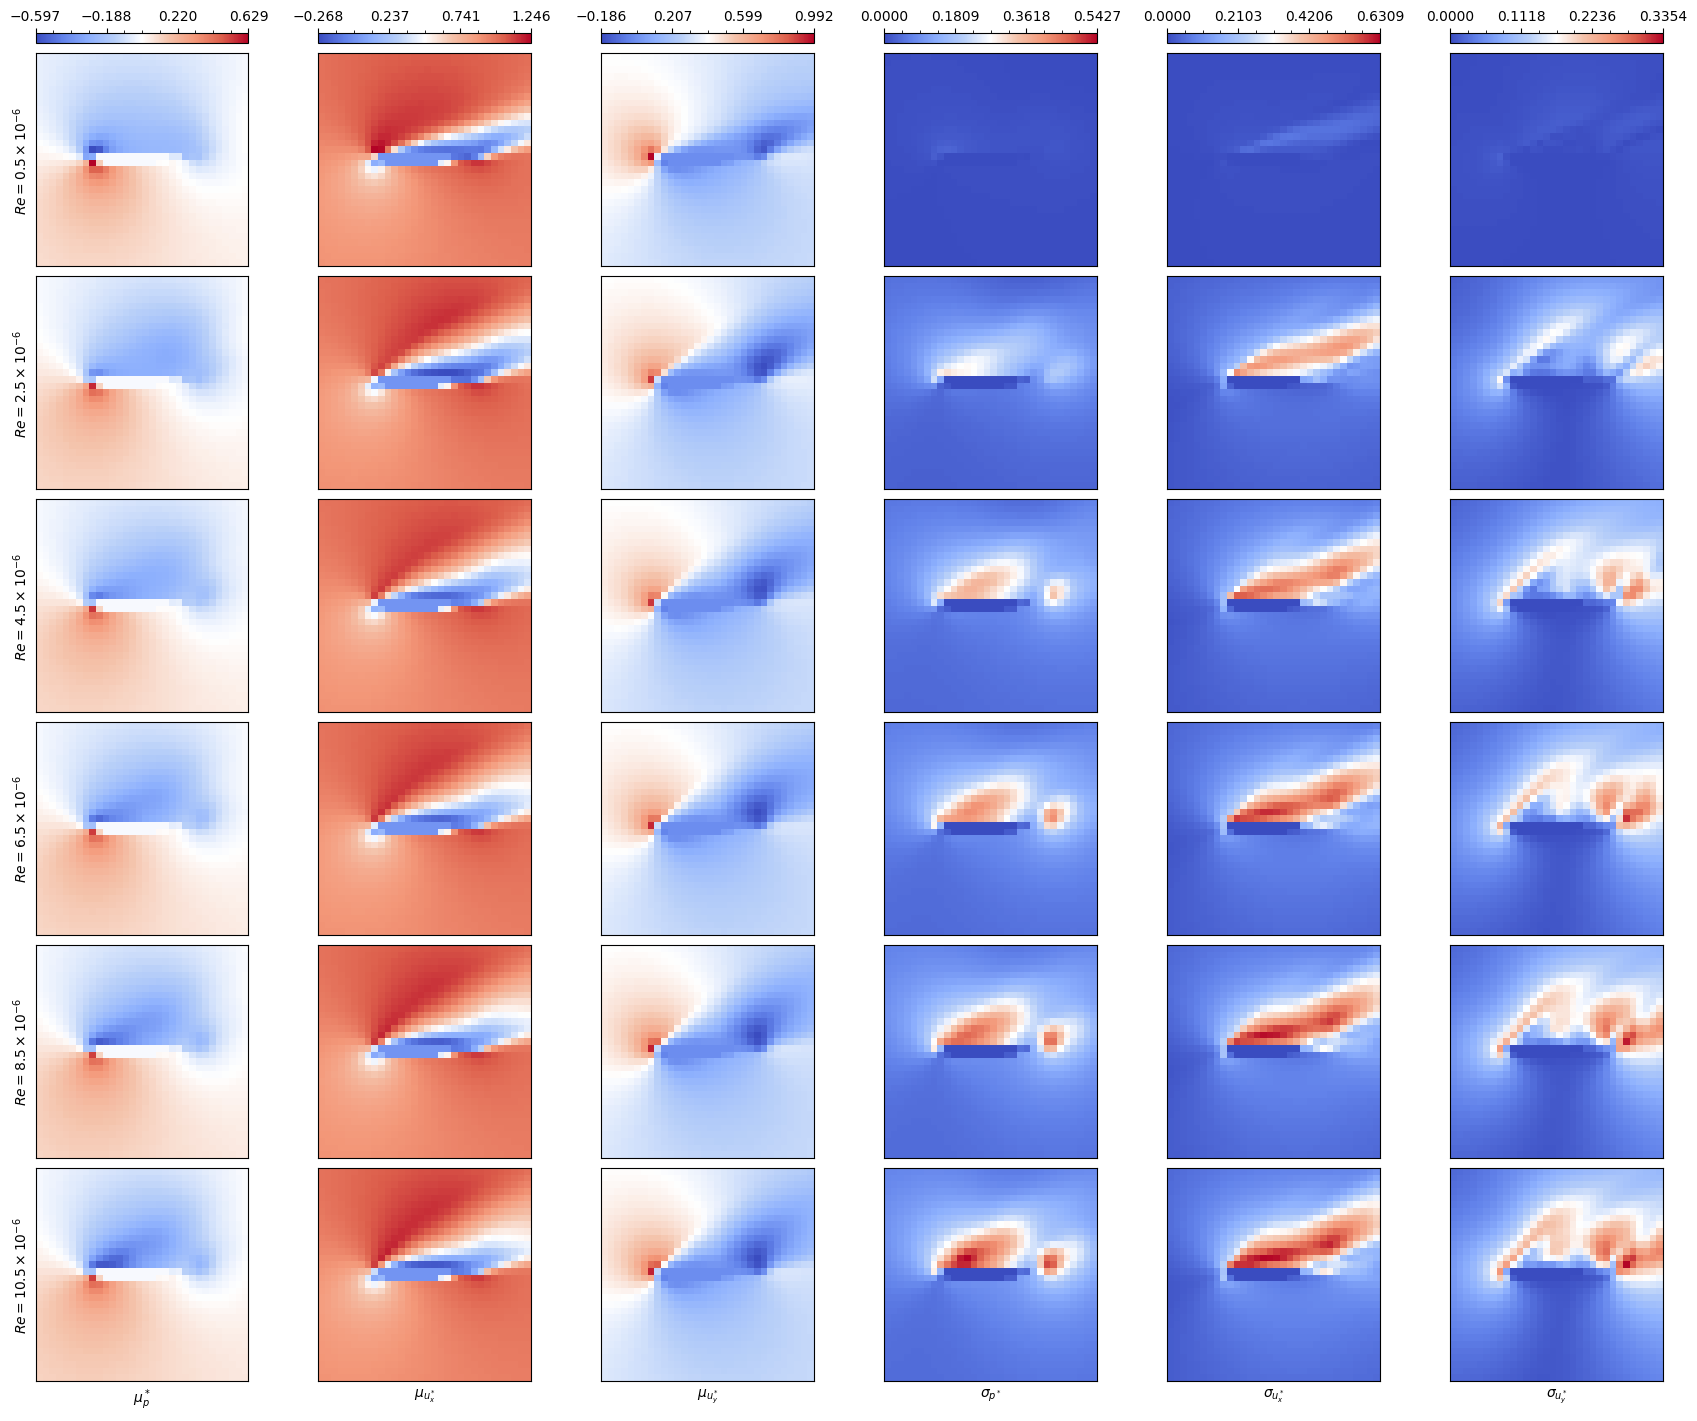

In [3]:
df_test.sort()
std_field_test_gd=[]
mean_field_test_gd=[]
inputs_test=[]
samples_gd=[]
for case in df_test.get_simulation_cases():
    datas=[]
    selected_cases=df_test.select_simulation_cases([case])
    for case in selected_cases:
        raw_data=read_single_file(case['path']+case['file_name'],model="dimless",scale_factor=0.25)
        datas.append(
            raw_data[3:]
            )
    inputs_test.append(read_single_file(case['path']+case['file_name'],model="normalized",scale_factor=0.25)[0:3])
    samples_gd.append(np.stack(datas,axis=0))
    std_field_test_gd.append(samples_gd[-1].std(axis=0))
    mean_field_test_gd.append(samples_gd[-1].mean(axis=0))
std_field_test_gd=np.stack(std_field_test_gd,axis=0)
mean_field_test_gd=np.stack(mean_field_test_gd,axis=0)

from airfoil_diffusion.plotter import *
CHANNEL_NAME_MEAN=[r"$\mu_p^*$",r"$\mu_{u_x^*}$",r"$\mu_{u_y^*}$"]
CHANNEL_NAME_STD=[r"$\sigma_{p^*}$",r"$\sigma_{u_x^*}$",r"$\sigma_{u_y^*}$"]
show_each_channel(np.concatenate([mean_field_test_gd,std_field_test_gd],axis=1),
                  channel_names=CHANNEL_NAME_MEAN+CHANNEL_NAME_STD,
                  case_names=[r"$Re={}\times$".format(0.5 +2*i)+"$10^{-6}$" for i in range(6)],transpose=True,inverse_y=True)

In [ ]:
mean_field_test_gd.shape

(6, 3, 32, 32)

In [ ]:
std_field_test_gd.shape

(6, 3, 32, 32)

To predict the mean and standard deviation distributions for given input condition

In [4]:
def sample_diffusion(network,input_field,num_diffusion_sample=100):
    network.eval();network.to(device);predictions=[]
    batch_size=25;N_all=num_diffusion_sample
    diffuser=Cos2ParamsDiffuser(200,device=device)
    while True:
        if N_all<=0:
            break
        if N_all<batch_size:
            batch_size_now=N_all
            N_all=0
        else:
            N_all-=batch_size
            batch_size_now=batch_size
        prediction_batch=normalized2dimless(diffuser.sample_from_noise(network,input_field.to(device).repeat(batch_size_now,1,1,1),show_progress=False))
        predictions.append(prediction_batch.detach().cpu().numpy())
    predictions=np.concatenate(predictions,axis=0)
    return np.mean(predictions,axis=0),np.std(predictions,axis=0),predictions

Now, To Sample from Models Traineed Using different Conditioning Mechanisms

1.   Concatenation with no Conditional Cross Attention
2.   Conditional Cross Attention with concatenation
3.   Conditional Cross Attention with no  concatenation (Sufix "_nc")


Model naming format .
    nm_'x'ca'y'sa_'v'

    'x'ca = X number of cross attention layers
    'y'sa = X number of self attention layers
    'v' = 'nc' when concatenation is applied and absent when not applied

Load Models

In [5]:
index=4

input_field=inputs_test[index].unsqueeze(0)

dif_network=AifNet("./pre_trained/single_parameter/32/diffusion/network_configs.yaml") #No coditional attention
nm_1ca2sa = AifNet("./Test_Models/No_masking/1ca2sa_layers/network_configs.yaml") #Conditional attention with no masking
nm_2ca2sa = AifNet("./Test_Models/No_masking/2ca2sa_layers/network_configs.yaml") #2 Up sampling Conditional attention layers with no masking

nm_2ca2sa_nc = AifNet("./Test_Models/No_masking/2ca2sa_nc/network_configs.yaml") #Conditional attention with no masking
nm_4ca2sa_nc = AifNet("./Test_Models/No_masking/4ca2sa_nc/network_configs.yaml") #2 Up sampling Conditional attention layers with no masking

nm_4ca2sa = AifNet("./Test_Models/No_masking/4ca2sa/network_configs.yaml") #Conditional attention with no masking
nm_4ca4sa = AifNet("./Test_Models/No_masking/4sa4ca/network_configs.yaml") #2 Up sampling Conditional attention layers with no masking




In [6]:


nm_4ca4sa.load_state_dict(torch.load("./Test_Models/No_masking/4sa4ca/trained_network_weights.pt"))
nm_4ca2sa.load_state_dict(torch.load("./Test_Models/No_masking/4ca2sa/trained_network_weights.pt"))

nm_4ca2sa_nc.load_state_dict(torch.load("./Test_Models/No_masking/4ca2sa_nc/trained_network_weights.pt"))
nm_2ca2sa_nc.load_state_dict(torch.load("./Test_Models/No_masking/2ca2sa_nc/trained_network_weights.pt"))

nm_2ca2sa.load_state_dict(torch.load("./Test_Models/No_masking/2ca2sa_layers/trained_network_weights.pt"))
nm_1ca2sa.load_state_dict(torch.load("./Test_Models/No_masking/1ca2sa_layers/trained_network_weights.pt"))
dif_network.load_state_dict(torch.load("./pre_trained/single_parameter/32/diffusion/weights_0.pt"))



<ipython-input-6-9c9a00603449>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nm_4ca4sa.load_state_dict(torch.load("./Test_Models/No_masking/4sa4ca/trained_network_weights

<All keys matched successfully>

Select Test case

In [7]:
index=4

input_field=inputs_test[index].unsqueeze(0)


Generate Samples

In [8]:
mean,std,samples_diffusion=sample_diffusion(dif_network,input_field,num_diffusion_sample=100)
mean_nm_1ca2sa,std_nm_1ca2sa,samples_diffusion_nm_n1ca2sa=sample_diffusion(nm_1ca2sa,input_field,num_diffusion_sample=100)
mean_nm_2ca2sa,std_nm_2ca2sa,samples_diffusion_nm_n2ca2sa=sample_diffusion(nm_2ca2sa,input_field,num_diffusion_sample=100)
mean_nm_2ca2sa_nc,std_nm_2ca2sa_nc,samples_diffusion_nm_n2ca2sa_nc=sample_diffusion(nm_2ca2sa_nc,input_field,num_diffusion_sample=100)
mean_nm_4ca2sa,std_nm_4ca2sa,samples_diffusion_nm_n4ca2sa=sample_diffusion(nm_4ca2sa,input_field,num_diffusion_sample=100)
mean_nm_4ca2sa_nc,std_nm_4ca2sa_nc,samples_diffusion_nm_n4ca4sa_nc=sample_diffusion(nm_4ca2sa_nc,input_field,num_diffusion_sample=100)
mean_nm_4ca4sa,std_nm_4ca4sa,samples_diffusion_nm_n4ca2sa=sample_diffusion(nm_4ca2sa,input_field,num_diffusion_sample=100)



Create datasets

In [9]:
result_diffusion=np.concatenate([mean,std],axis=0)
result_diffusion_nm_1ca2sa=np.concatenate([mean_nm_1ca2sa,std_nm_1ca2sa],axis=0)
result_diffusion_nm_2ca2sa=np.concatenate([mean_nm_2ca2sa,std_nm_2ca2sa],axis=0)
result_diffusion_nm_2ca2sa_nc=np.concatenate([mean_nm_2ca2sa_nc,std_nm_2ca2sa_nc],axis=0)
result_diffusion_nm_4ca2sa=np.concatenate([mean_nm_4ca2sa,std_nm_4ca2sa],axis=0)
result_diffusion_nm_4ca2sa_nc=np.concatenate([mean_nm_4ca2sa_nc,std_nm_4ca2sa_nc],axis=0)
result_diffusion_nm_4ca4sa=np.concatenate([mean_nm_4ca4sa,std_nm_4ca4sa],axis=0)

# Qualitative comparisons.

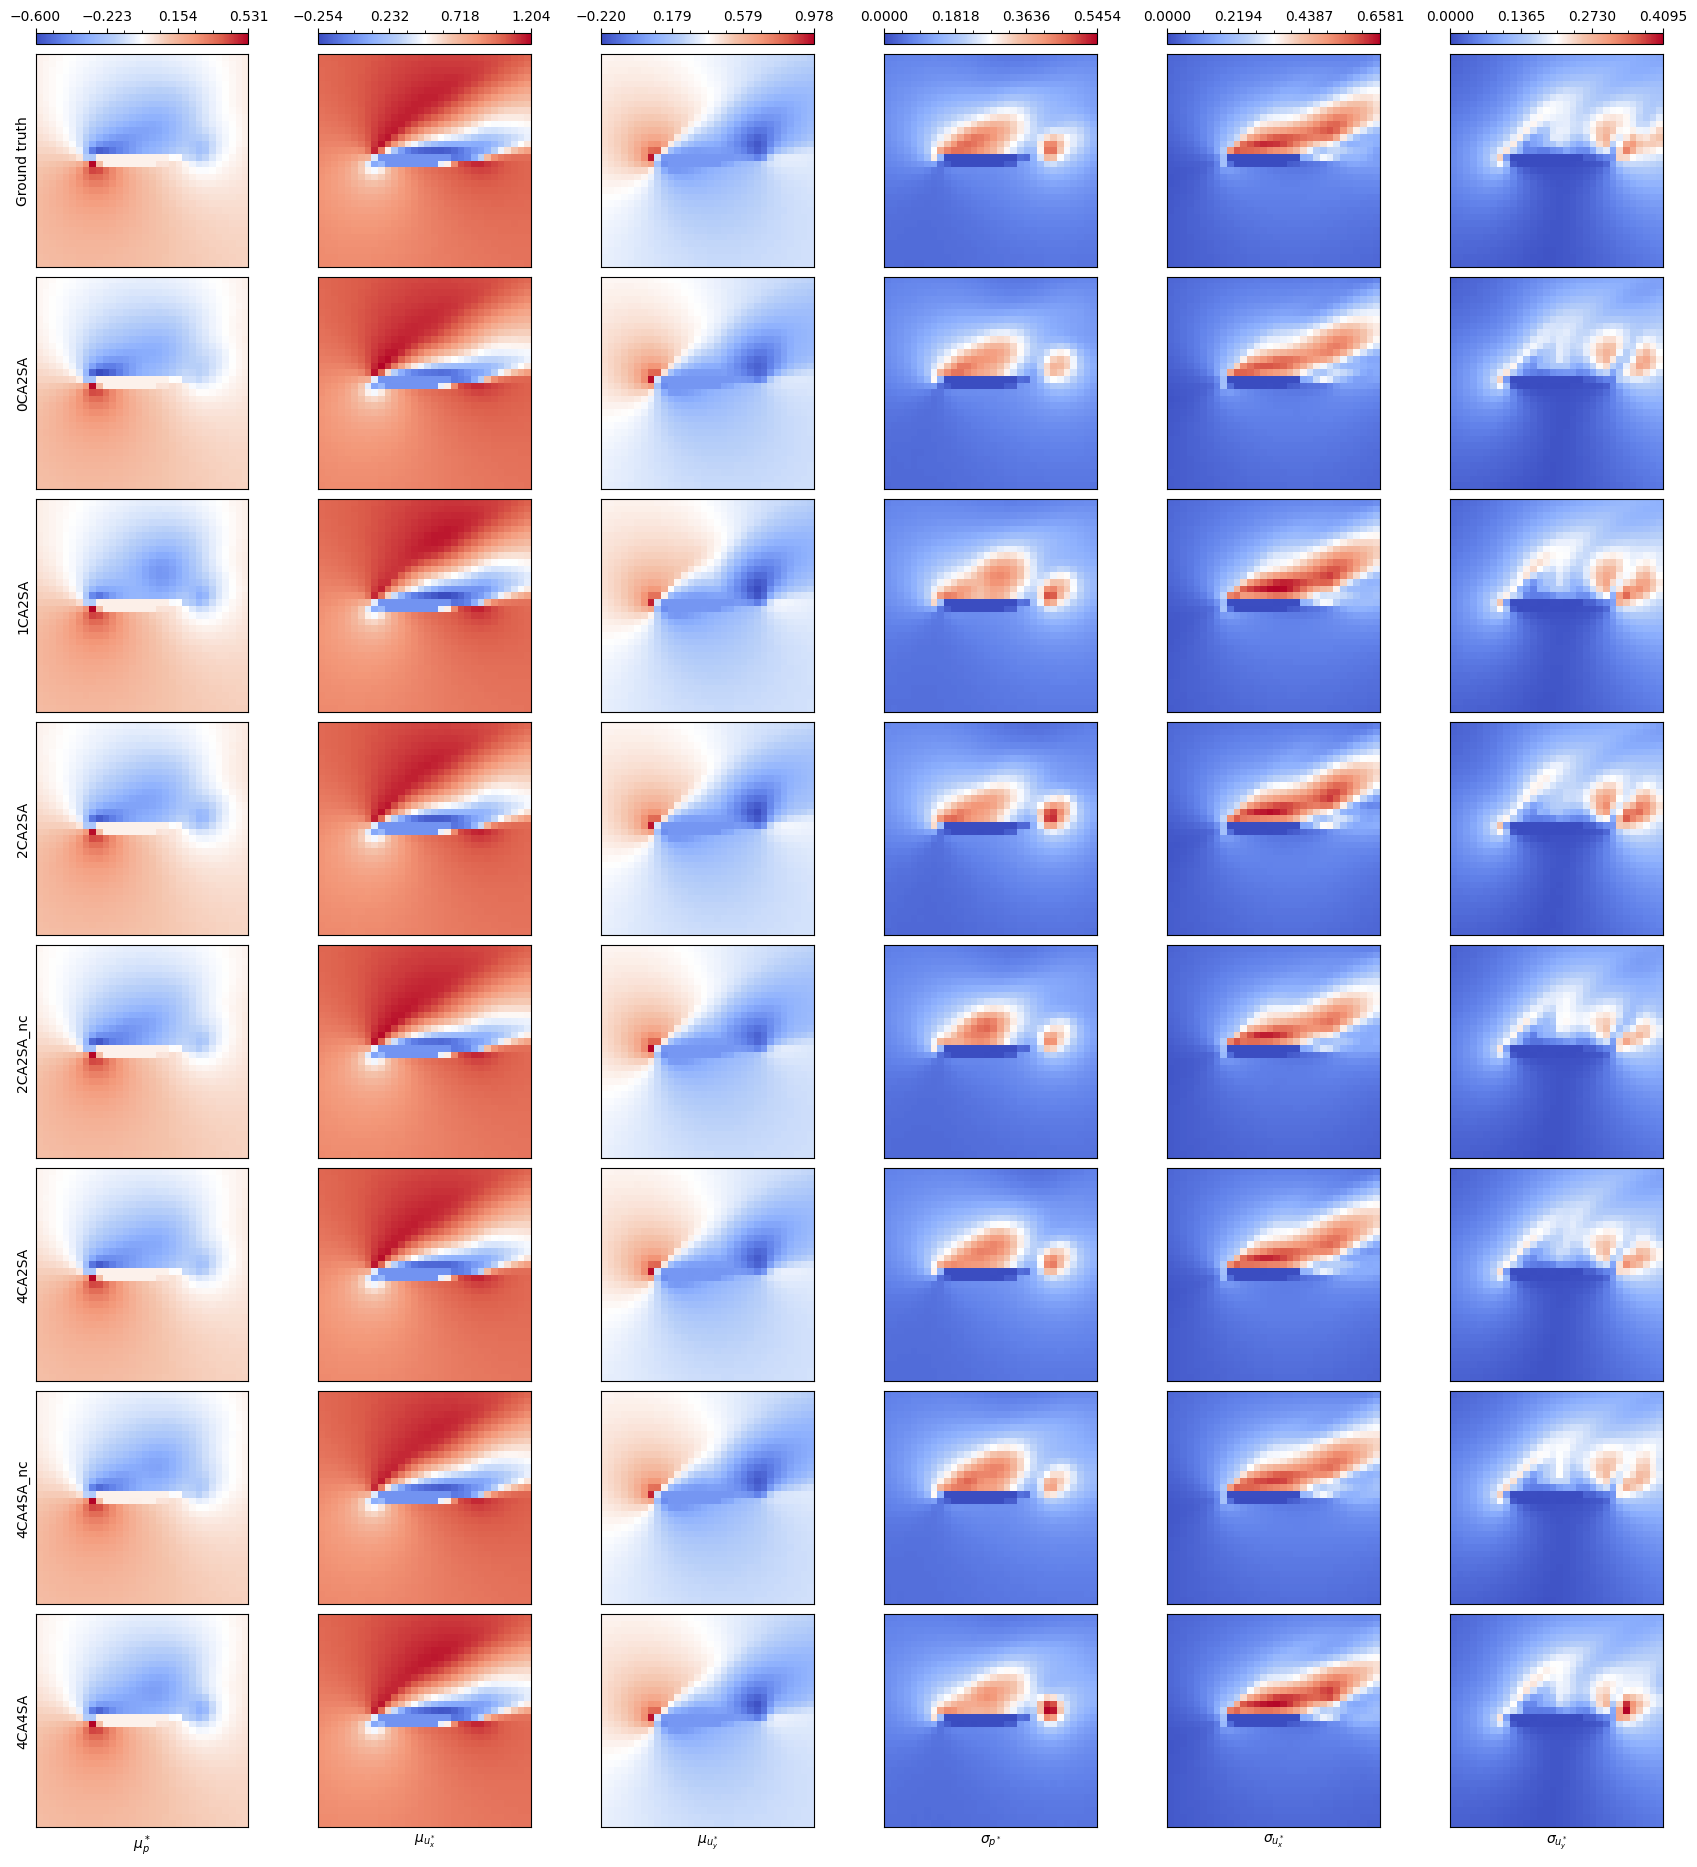

In [10]:
result_ground_truth=np.concatenate([mean_field_test_gd[index],std_field_test_gd[index]],axis=0)
show_each_channel([result_ground_truth,result_diffusion, result_diffusion_nm_1ca2sa,result_diffusion_nm_2ca2sa, result_diffusion_nm_2ca2sa_nc, result_diffusion_nm_4ca2sa,result_diffusion_nm_4ca2sa_nc, result_diffusion_nm_4ca4sa],
                  channel_names=CHANNEL_NAME_MEAN+CHANNEL_NAME_STD,
                  case_names=["Ground truth","0CA2SA", "1CA2SA", "2CA2SA", "2CA2SA_nc", "4CA2SA","4CA4SA_nc","4CA4SA"],transpose=True,inverse_y=True)

# Quantifying the Performance

Step 1: Compute the errors

In [11]:
from os import error
p_samples_diffusion = torch.tensor(result_diffusion)
p_samples_gd = torch.tensor(result_ground_truth)
p_samples_diffusion_nm_1ca2sa = torch.tensor(result_diffusion_nm_1ca2sa)
p_samples_diffusion_nm_2ca2sa = torch.tensor(result_diffusion_nm_2ca2sa)
p_samples_diffusion_nm_2ca2sa_nc = torch.tensor(result_diffusion_nm_2ca2sa_nc)
p_samples_diffusion_nm_4ca2sa = torch.tensor(result_diffusion_nm_4ca2sa)
p_samples_diffusion_nm_4ca2sa_nc = torch.tensor(result_diffusion_nm_4ca2sa_nc)
p_samples_diffusion_nm_4ca4sa = torch.tensor(result_diffusion_nm_4ca4sa)

error_diffusion = torch.abs(p_samples_diffusion - p_samples_gd)
error_diffusion_nm_1ca2sa = torch.abs(p_samples_diffusion_nm_1ca2sa - p_samples_gd)
error_diffusion_nm_2ca2sa = torch.abs(p_samples_diffusion_nm_2ca2sa - p_samples_gd)
error_diffusion_nm_2ca2sa_nc = torch.abs(p_samples_diffusion_nm_2ca2sa_nc - p_samples_gd)
error_diffusion_nm_4ca2sa = torch.abs(p_samples_diffusion_nm_4ca2sa - p_samples_gd)
error_diffusion_nm_4ca2sa_nc = torch.abs(p_samples_diffusion_nm_4ca2sa_nc - p_samples_gd)
error_diffusion_nm_4ca4sa = torch.abs(p_samples_diffusion_nm_4ca4sa - p_samples_gd)

# Step 2: Plot the errors

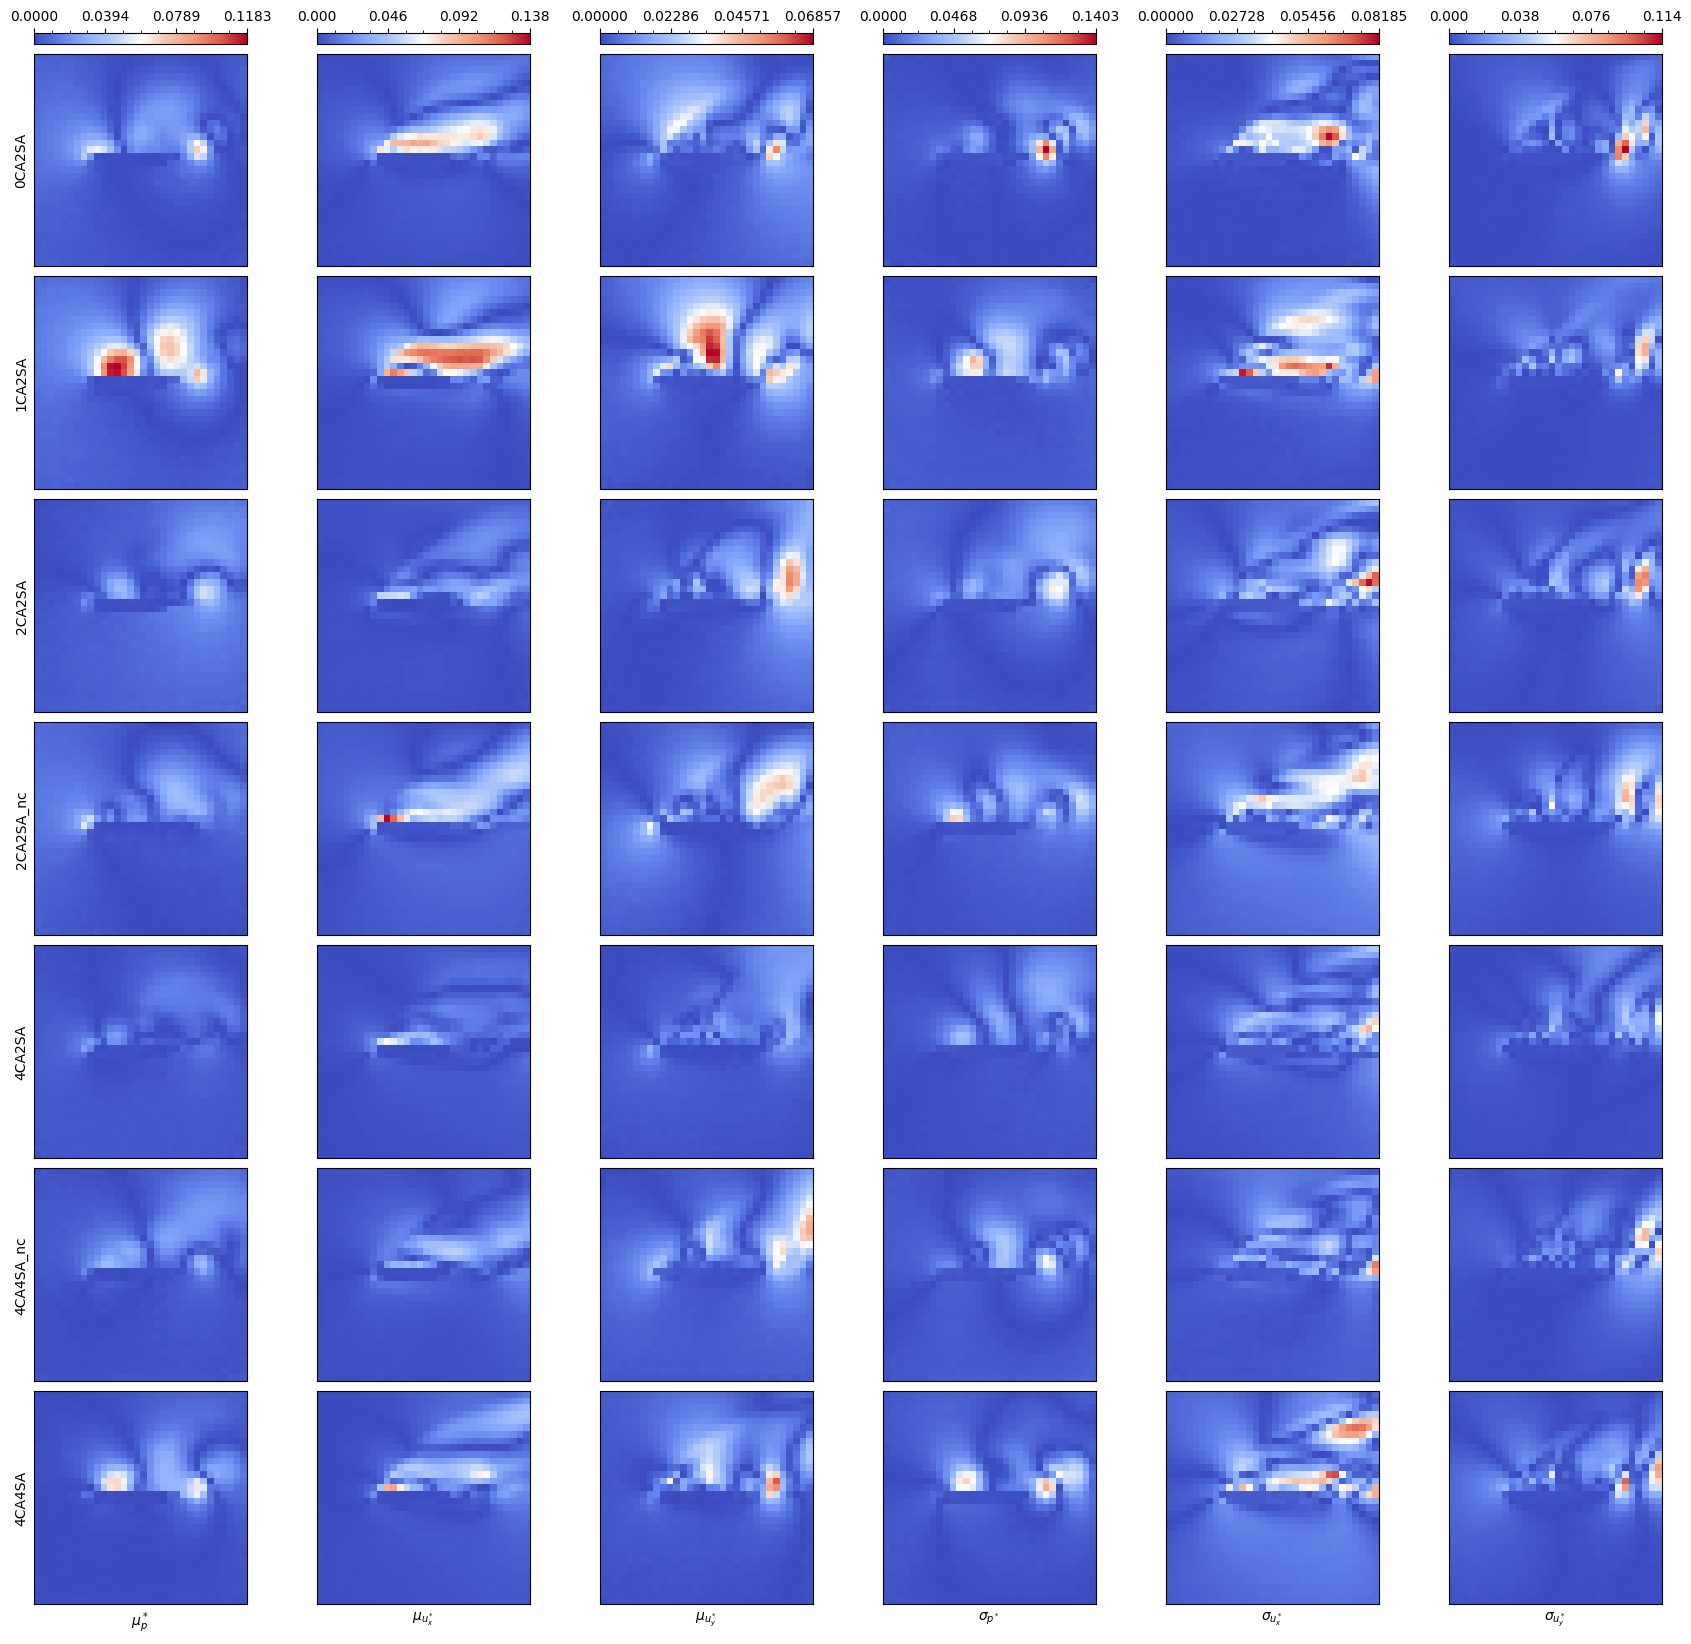

In [12]:
show_each_channel(
    [error_diffusion, error_diffusion_nm_1ca2sa, error_diffusion_nm_2ca2sa,error_diffusion_nm_2ca2sa_nc, error_diffusion_nm_4ca2sa, error_diffusion_nm_4ca2sa_nc, error_diffusion_nm_4ca4sa],
    channel_names=CHANNEL_NAME_MEAN+CHANNEL_NAME_STD,
    case_names=["0CA2SA", "1CA2SA", "2CA2SA", "2CA2SA_nc", "4CA2SA","4CA4SA_nc","4CA4SA"],
    transpose=True, inverse_y=True
)

# Step 3: Plot  Performance for 500 samples errors

In [13]:
df_all.sort()
std_groundtruth=[]
mean_groundtruth=[]
for case in df_all.get_simulation_cases():
    datas=[]
    selected_cases=df_all.select_simulation_cases([case])
    for case in selected_cases:
        datas.append(
            read_single_file(case['path']+case['file_name'],model="dimless",scale_factor=0.25)[3:] # scale factor is 0.25 to geet 32 $\times$ 32 data
            )
    std_groundtruth.append(np.stack(datas,axis=0).std(axis=0).mean())
    mean_groundtruth.append(np.mean(datas,axis=(1,2,3)))

By performing the sampling on the whole test dataset, we can compare our predictions with the ground truth:

In [14]:
def do_test(sample_func):
    mean_predictions=[]
    std_predictions=[]
    std_a_predictions=[]
    for input_field in tqdm(inputs_test):
        mean_fields,std_fields,_=sample_func(input_field.unsqueeze(0))
        mean_predictions.append(mean_fields)
        std_predictions.append(std_fields)
        std_a_predictions.append(np.mean(std_fields))
    return mean_predictions,std_predictions,std_a_predictions

Split the sampling to stop browser from crashing

In [15]:
mean_predictions_dif,std_predictions_dif,std_a_predictions_dif=do_test(lambda x:sample_diffusion(dif_network,x,num_diffusion_sample=500));
mean_predictions_nm_1ca2sa,std_predictions_nm_1ca2sa,std_a_predictions_nm_1ca2sa=do_test(lambda x:sample_diffusion(nm_1ca2sa,x,num_diffusion_sample=500))
mean_predictions_nm_2ca2sa,std_predictions_nm_2ca2sa,std_a_predictions_nm_2ca2sa=do_test(lambda x:sample_diffusion(nm_2ca2sa,x,num_diffusion_sample=500))


100%|██████████| 6/6 [06:06<00:00, 61.00s/it]


In [16]:
mean_predictions_nm_2ca2sa_nc,std_predictions_nm_2ca2sa_nc,std_a_predictions_nm_2ca2sa_nc=do_test(lambda x:sample_diffusion(nm_2ca2sa_nc,x,num_diffusion_sample=500))
mean_predictions_nm_4ca2sa,std_predictions_nm_4ca2sa,std_a_predictions_nm_4ca2sa=do_test(lambda x:sample_diffusion(nm_4ca2sa,x,num_diffusion_sample=500))


100%|██████████| 6/6 [13:46<00:00, 137.83s/it]


In [17]:
mean_predictions_nm_4ca2sa_nc,std_predictions_nm_4ca2sa_nc,std_a_predictions_nm_4ca2sa_nc=do_test(lambda x:sample_diffusion(nm_4ca2sa_nc,x,num_diffusion_sample=500))
mean_predictions_nm_4ca4sa,std_predictions_nm_4ca4sa,std_a_predictions_nm_4ca4sa=do_test(lambda x:sample_diffusion(nm_4ca4sa,x,num_diffusion_sample=500))

100%|██████████| 6/6 [22:58<00:00, 229.78s/it]


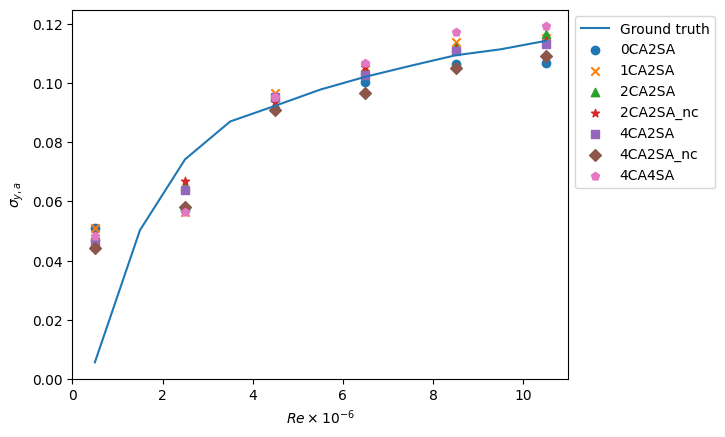

In [21]:
x=[0.5 +2*i for i in range(6)]
plt.plot([0.5 +i for i in range(11)],std_groundtruth,label="Ground truth")
plt.scatter(x,std_a_predictions_dif,label="0CA2SA",marker="o")
plt.scatter(x,std_a_predictions_nm_1ca2sa,label="1CA2SA",marker="x")
plt.scatter(x,std_a_predictions_nm_2ca2sa,label="2CA2SA",marker="^")
plt.scatter(x,std_a_predictions_nm_2ca2sa_nc,label="2CA2SA_nc",marker="*")
plt.scatter(x,std_a_predictions_nm_4ca2sa,label="4CA2SA",marker="s")
plt.scatter(x,std_a_predictions_nm_4ca2sa_nc,label="4CA2SA_nc",marker="D")
plt.scatter(x,std_a_predictions_nm_4ca4sa,label="4CA4SA",marker="p")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel(r"$Re \times 10^{-6}$")
plt.ylabel(r"$\sigma_{y,a}$")
plt.show()

In [25]:
len(mean_predictions_nm_1ca2sa)

6